# Preconditioner Series: Cholesky Decomposition

In this notebook, we implement our own Cholesky decomposition algorithm and compare its performance to NumPy's implementation. We also explore variants of the Cholesky decomposition such as:
- Cholesky-Banachiewicz factorization
- Cholesky-Crout factorization
- LDL
- Incomplete Cholesky factorization

If you are unfamiliar with preconditioners, I suggest looking through the ['Preconditioner Series: Introduction to Preconditioners']() notebook first.

## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
# from sksparse.cholmod import cholesky as sp_cholesky
from scipy.linalg import ldl
from scipy import sparse
from numba import jit

%matplotlib inline

## What is it?

The Cholesky decomposition offers an efficient method to calculate numerical solutions to linear equations $Ax=b$ when $A$ is **symmetric (Hermitian if complex)** and **positive definite**. When this is the case, we can decompose $A$ into two matrices:

$$ A=LL^* $$

where $L$ is a lower triangular matrix with real, positive diagonal entries, and $L^*$ is the conjugate transpose of $L$. In the case that $A$ is symmetric and positive definite, $L^*=L^T$.

## Why do it?

When solving linear equations $Ax=b$, the Cholesky decomposition breaks down $Ax=b$ into easier problems. Here are the steps:

1. Cholesky decomposition:  $$ A=LL^* $$
2. Substitute $LL^*$ for $A$:  $$ Ax=LL^*x=b $$
3. Create a new variable $y$:  $$ y=L^*x $$
4. Substitute $y$ into equation from (2) and solve for $y$:  $$ Ly=b $$
5. Solve for $x$:  $$ L^*x=y $$

The efficiency of this method stems from the fact that $L$ and $L^*$ are both triangular matrices, which means that steps 4 and 5 can be performed efficiently.

## How do we do it?

The Cholesky-Banachiewicz and Cholesky-Crout algorithms for the Cholesky decomposition are quite simple and can be derived by writing out the decomposition of A in terms of variables:

<img src="img/cholesky_deriv.png" alt="term-document matrix" style="width: 60%"/>

From the matrix above, we can derive separate formulas for the diagonals and non-diagonal elements of $L$ for $A$ with $i$ rows and $k$ columns:

$$\begin{align}
l_{kk} &= \sqrt{a_{kk}-\sum_{j=1}^{k-1}l_{kj}^2}\\
l_{ik} &= \frac{1}{l_{kk}}\bigg(a_{ik}-\sum_{j=1}^{k-1}l_{ij}l_{kj}\bigg)\ \ \ \text{for}\ i>k
\end{align}$$

The only difference between the two algorithms is the order by which the elements of $L$ are calculated. In Cholesky-Banachiewicz, the elements are calculated row-by-row starting from the top left. Cholesky-Crout starts at the top left as well but proceeds column-by-column.

## Cholesky decomposition from scratch

Here I have a function that performs the Cholesky decomposition using the Cholesky-Banachiewicz algorithm. It is not the most efficient implementation, but, in my opinion, it is easy to read and that is what I prioritized.

In [5]:
def my_cholesky(A):
    rows, _ = A.shape
    L = np.zeros((rows, rows))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if (i == k):
                L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
            else:
                L[i, k] = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
    return L

### Comparison to NumPy's *cholesky*

Let's first create a symmetric, positive definite matrix.

In [6]:
A = make_spd_matrix(5)
A.shape

(5, 5)

In [9]:
%time L_np = np.linalg.cholesky(A)
L_np

CPU times: user 65 µs, sys: 1e+03 ns, total: 66 µs
Wall time: 70.1 µs


array([[ 0.74370349,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.07926308,  0.66583594,  0.        ,  0.        ,  0.        ],
       [ 0.41742439, -0.96848621,  1.82952591,  0.        ,  0.        ],
       [ 0.36211793, -0.39384795,  0.55982674,  0.74998524,  0.        ],
       [-0.38855599, -0.1282391 , -0.52432797, -0.19952331,  0.51759632]])

In [10]:
%time L = my_cholesky(A)
L, np.allclose(L, L_np)

CPU times: user 106 µs, sys: 1e+03 ns, total: 107 µs
Wall time: 111 µs


(array([[ 0.74370349,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.07926308,  0.66583594,  0.        ,  0.        ,  0.        ],
        [ 0.41742439, -0.96848621,  1.82952591,  0.        ,  0.        ],
        [ 0.36211793, -0.39384795,  0.55982674,  0.74998524,  0.        ],
        [-0.38855599, -0.1282391 , -0.52432797, -0.19952331,  0.51759632]]),
 True)

Although my implementation of the Cholesky decomposition takes roughly 1.5 to 2 times to that of NumPy, we got the same answer. For larger matrices, my implementation still computes the answer correctly albeit orders of magnitude slower.

In [12]:
A = make_spd_matrix(100)
%time L_np = np.linalg.cholesky(A)
%time L = my_cholesky(A)
np.allclose(L_np, L)

CPU times: user 888 µs, sys: 154 µs, total: 1.04 ms
Wall time: 824 µs
CPU times: user 264 ms, sys: 3.47 ms, total: 267 ms
Wall time: 145 ms


True

Let's try speeeding things up with Numba's @jit decorator.

In [86]:
@jit
def my_cholesky_jit(A):
    rows, cols = A.shape
    L = np.zeros((rows, cols))
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, rows):
        for k in range(i + 1):
            if (i == k):
                L[i, k] = np.sqrt(A[i, k] - sum([L[k, j] ** 2 for j in range(k)]))
            else:
                L[i, k] = (A[i, k] - sum([L[i, j] * L[k, j] for j in range(k)])) / L[k, k]
    return L

In [87]:
%time L_jit = my_cholesky_jit(A)

AssertionError: Failed at object (object mode frontend)


## Variants to the Cholesky decomposition

### LDL

An alternative to the Cholesky decomposition is the LDL decomposition, also known as the symmetric indefinite factorization. 

<img src="img/ldl_3by3.png" alt="term-document matrix" style="width: 70%"/>

$$\begin{align}D_j &= A_{jj}-\sum_{k=1}^{j-1}L_{jk}^2D_k \\
L_{ij} &= \frac{1}{D_j}\bigg(A_{ij}-\sum_{k=1}^{j-1}L_{ik}L_{jk}D_k \bigg)\ \text{for}\ i>j\end{align}$$

In [13]:
def my_ldl(A):
    rows, _ = A.shape
    L = np.eye(rows)
    D = np.zeros((rows,))
    
    for i in range(1, rows):
        for j in range(i + 1):
            D[j] = A[j,j] - sum([D[k] * L[j, k] ** 2 for k in range(j)])
            L[i, j] = (A[i, j] - sum([L[i, k] * L[j, k] * D[k] for k in range(j)])) / D[j]
    return L, D

In [14]:
A = make_spd_matrix(5)

In [15]:
%time L, D = my_ldl(A)
L, np.diag(D), np.allclose(A, L @ np.diag(D) @ L.T)

CPU times: user 149 µs, sys: 10 µs, total: 159 µs
Wall time: 163 µs


(array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.16708038,  1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.18945546, -0.69610648,  1.        ,  0.        ,  0.        ],
        [ 0.68223295, -0.95477259,  0.96371125,  1.        ,  0.        ],
        [-0.16975679,  0.07001165, -0.1064713 , -0.07615058,  1.        ]]),
 array([[0.49055855, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.88408598, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.43579403, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.78180648, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.55513249]]),
 True)

In [16]:
%time lu, d, perm = ldl(A)
lu, d, perm

CPU times: user 1.7 ms, sys: 1.51 ms, total: 3.21 ms
Wall time: 5.03 ms


(array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.16708038,  1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.18945546, -0.69610648,  1.        ,  0.        ,  0.        ],
        [ 0.68223295, -0.95477259,  0.96371125,  1.        ,  0.        ],
        [-0.16975679,  0.07001165, -0.1064713 , -0.07615058,  1.        ]]),
 array([[0.49055855, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.88408598, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 1.43579403, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.78180648, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.55513249]]),
 array([0, 1, 2, 3, 4]))

### Incomplete Cholesky factorization

Of course, like any decomposition algorithm in numerical linear algebra, the Cholesky decomposition has a variation that calculates a sparse approximation of it.

$$ A\approx KK^* $$

In [17]:
def my_ichol(A, mode=0):
    rows, cols = A.shape
    K = np.zeros((rows, cols))
    
    if mode == 0:
        K[0, 0] = np.sqrt(A[0, 0])
    
        for i in range(1, rows):
            for k in range(i + 1):
                if (A[i, k] != 0):
                    if (i == k):
                        K[i, k] = np.sqrt(A[i, k] - sum([K[k, j] ** 2 for j in range(k)]))
                    else:
                        K[i, k] = (K[i, k] - sum([K[i, j] * K[k, j] for j in range(k)])) / K[k, k]
        
    return K

To test this algorithm, we need to create a sparse symmetric positive definite matrix.

In [18]:
def make_sparsespd_matrix(n):
    A = sparse.random(n, n, density=0.05)
    A = A @ A.T
    
    A = A + n * sparse.eye(n)
        
    return A

Here we can see that sparsity pattern of the matrix $A$ created.

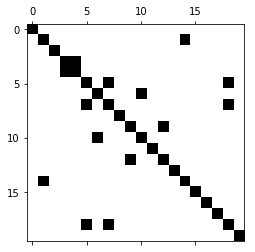

In [19]:
A = make_sparsespd_matrix(20).todense()
plt.spy(A);

Now, we can test our incomplete Cholesky factorization algorithm.

CPU times: user 775 µs, sys: 11 µs, total: 786 µs
Wall time: 782 µs


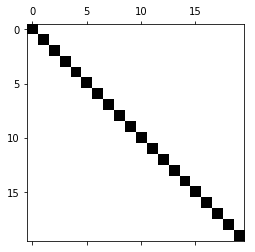

In [20]:
%time K = my_ichol(A)

plt.spy(K);

#### Comparison with *scikit.sparse* implementation

As I did before, I compare the results of my function with that of a function written using the *scipy.sparse* library.

#### Comparison with (complete) Cholesky factorization

By comparing the sparsity patterns of the two methods, we can see how much 
memory can be saved at the expense of some accuracy.

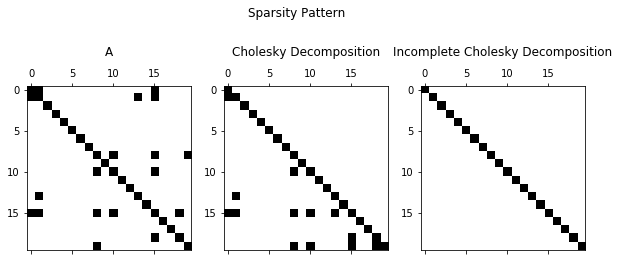

In [69]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
plt.spy(A);
ax1.set_title('A', y=1.15);

ax2 = fig.add_subplot(1, 3, 2)
plt.spy(np.linalg.cholesky(A));
ax2.set_title('Cholesky Decomposition', y=1.15);

ax3 = fig.add_subplot(1, 3, 3)
plt.spy(K);
ax3.set_title('Incomplete Cholesky Decomposition', y=1.15);

plt.suptitle('Sparsity Pattern', y=0.95);

## Resources

[Cholesky decomposition algorithm derivation](https://rosettacode.org/wiki/Cholesky_decomposition)

[MATLAB: Cholesky factorization](https://www.mathworks.com/help/matlab/ref/chol.html)

[MATLAB: Incomplete Cholesky factorization](https://www.mathworks.com/help/matlab/ref/ichol.html)